In [2]:
!pip install yfinance

  Using cached yfinance-0.2.56-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.17.9-cp311-cp311-linux_x86_64.whl
Using cached yfinance-0.2.56-py2.py3-none-any.whl (113 kB)
Using cached frozendict-2.4.6-py311-none-any.whl (16 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [3]:
import yfinance as yf, numpy as np, pandas as pd
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

# Import daily stock price data using adjusted closing prices
ticker = "AC.TO"
data = yf.download(
    ticker,
    start="2021-04-24",
    end="2025-04-24",
    auto_adjust=True,
    progress=False
)
equity_prices = data['Close']

# Daily volatility computation
sigma_daily = equity_prices.pct_change().dropna().std()

# Annualizing daily volatility using 252 trading days
sigma_E = sigma_daily * np.sqrt(252)

# Computation of equity market value on the last trading day before (and including) 2025-04-23
shares_out = yf.Ticker(ticker).info['sharesOutstanding']
E = equity_prices.iloc[-1] * shares_out

# Turn values into scalars
sigma_E = float(sigma_E.squeeze())  
E       = float(E.squeeze())  
sigma_E

0.3522066891209901

In [4]:
fx_usdcad      = 1.39        # spot FX on quote date

# --- face amounts -------------------------------------------
face_2029_cad  = 2_000_000_000      # CAD
face_2026_usd  = 1_200_000_000      # USD

D_market = face_2029_cad + face_2026_usd*fx_usdcad
print(f"Market value of debt  D = {D_market/1e9:.2f} bn CAD")

Market value of debt  D = 3.67 bn CAD


In [5]:
rf = 0.03

In [6]:
# KMV Calibration
from scipy.optimize import fsolve
from scipy.stats   import norm
import numpy as np

def kmv_calibrate(E, sigma_E, D, r):
    """
    Calibrate V* (asset value) and σV* (asset vol) at T = 1 year.

    Uses log-volatility  w = log σV   so σV = exp w is always > 0.
    """
    def system(x):
        V, w = x
        sV = np.exp(w)                 # volatility is always positive
        if V <= D:                     # keep log well-defined
            return (1e9, 1e9)

        d1 = (np.log(V/D) + (r + 0.5*sV**2)) / sV   # T = 1
        d2 = d1 - sV
        eq1 = V*norm.cdf(d1) - D*np.exp(-r)*norm.cdf(d2) - E
        eq2 = sV*V*norm.cdf(d1)        - sigma_E*E
        return (eq1, eq2)

    # Initial Guess
    V0 = D * 1.30                      # 30 % cushion above debt
    w0 = np.log(max(0.30, sigma_E))    # log of a reasonable σV
    V_star, w_star = fsolve(system, (V0, w0), xtol=1e-10, maxfev=5000)
    return V_star, np.exp(w_star)


# 1-year Calibration
V_star, sigma_V_star = kmv_calibrate(E, sigma_E, D_market, rf)

print(f"Optimal asset value  V*  = {V_star/1e9:,.2f} bn CAD")
print(f"Optimal asset vol   σV* = {sigma_V_star:.2%}")

def kmv_pd_const(T, V=V_star, sV=sigma_V_star, D=D_market, r=rf):
    d2 = (np.log(V/D) + (r - 0.5*sV**2)*T) / (sV*np.sqrt(T))
    return norm.cdf(-d2)

Optimal asset value  V*  = 8.35 bn CAD
Optimal asset vol   σV* = 20.21%


In [7]:
horiz      = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
kmv_const  = {T: kmv_pd_const(T) for T in horiz}

print("\n=== KMV cumulative PDs ===")
for T in horiz:
    print(f"{T:>2}-yr : {kmv_const[T]*100:5.2f} %")


=== KMV cumulative PDs ===
 1-yr :  0.00 %
 2-yr :  0.16 %
 3-yr :  0.75 %
 4-yr :  1.66 %
 5-yr :  2.70 %
 6-yr :  3.77 %
 7-yr :  4.80 %
 8-yr :  5.78 %
 9-yr :  6.69 %
10-yr :  7.53 %
11-yr :  8.31 %
12-yr :  9.02 %
13-yr :  9.68 %
14-yr : 10.28 %
15-yr : 10.84 %
16-yr : 11.36 %
17-yr : 11.84 %
18-yr : 12.29 %
19-yr : 12.70 %
20-yr : 13.08 %


In [8]:
# Rating-based cumulative PD's
import numpy as np, pandas as pd

labels = ['AAA','AA','A','BBB','BB','B','CCC/C','D']
M1 = pd.DataFrame([
    # AAA  AA     A      BBB    BB     B     CCC/C   D        # ← columns
    [87.28, 8.92, 0.51,  0.03,  0.10, 0.03, 0.05,  0.00],   # AAA  ← rows
    [ 0.45,87.74, 7.50,  0.44,  0.05, 0.06, 0.02,  0.02],   # AA
    [ 0.02, 1.48,89.42,  4.64,  0.23, 0.10, 0.01,  0.05],   # A
    [ 0.00, 0.07, 3.05, 87.33,  3.21, 0.40, 0.09,  0.14],   # BBB  ← Air Canada row
    [ 0.01, 0.02, 0.10,  4.44, 78.89, 6.25, 0.50,  0.56],   # BB
    [ 0.00, 0.02, 0.06,  0.14,  4.47,75.18, 4.79,  2.93],   # B
    [ 0.00, 0.00, 0.07,  0.13,  0.40,13.18,45.07, 26.12],   # CCC/C
    [ 0.00, 0.00, 0.00,  0.00,  0.00, 0.00, 0.00,100.00]    # D  (absorbing)
], index=labels, columns=labels) / 100   # ← same table

state0 = np.zeros(len(labels));  state0[labels.index('BB')] = 1
D_idx  = labels.index('D')

cred_horiz = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
pd_cm = {}
for T in cred_horiz:
    MT = np.linalg.matrix_power(M1.values, T)
    pd_cm[T] = (state0 @ MT)[D_idx]


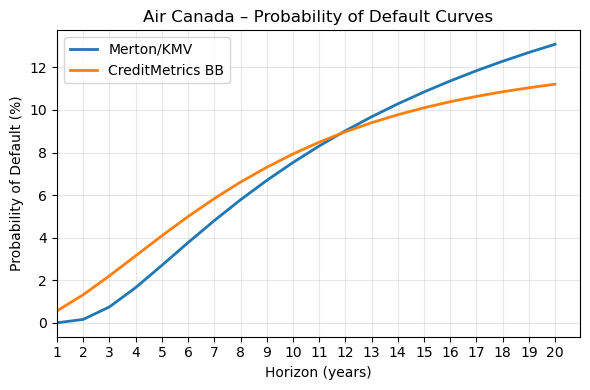

In [9]:
# AC Default Plots
import matplotlib.pyplot as plt, numpy as np

cm_x  = cred_horiz
cm_y  = np.array([pd_cm[t] for t in cm_x]) * 100
kmv_x = horiz
kmv_y = np.array([kmv_const[t] for t in kmv_x]) * 100

plt.figure(figsize=(6,4))
plt.plot(kmv_x, kmv_y, lw=2, label='Merton/KMV')
plt.plot(cm_x , cm_y , lw=2, label='CreditMetrics BB')

plt.xlim(left=1)               # ← start the x-axis at 1 year
plt.xticks(kmv_x)              # optional: integer tick labels only

plt.xlabel('Horizon (years)')
plt.ylabel('Probability of Default (%)')
plt.title('Air Canada – Probability of Default Curves')
plt.grid(alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# KMV Inputs and Transition Matrix
import pandas as pd, numpy as np
from IPython.display import display

kmv_inputs = pd.DataFrame({
    'value': [E, sigma_E, sigma_V_star, D_market, D_market/V_star],
    'fmt'  : ['bn CAD','%','%','bn CAD','×']
}, index=['S (equity)','σS','σA','D (market)','Leverage D/V*'])

kmv_inputs.loc['S (equity)', 'value']  /= 1e9
kmv_inputs.loc['D (market)', 'value']  /= 1e9
kmv_inputs.loc[['σS','σA'],'value']    *= 100

print("\n=== KMV-model inputs ===")
display(kmv_inputs.style.format({'value':'{:.2f}'}))

print("\n=== 1-year rating transition matrix (S&P 1981-2024) ===")
display((M1*100).style.format('{:.2f} %'))



=== KMV-model inputs ===


,value,fmt
S (equity),4.79,bn CAD
σS,35.22,%
σA,20.21,%
D (market),3.67,bn CAD
Leverage D/V*,0.44,×



=== 1-year rating transition matrix (S&P 1981-2024) ===


,AAA,AA,A,BBB,BB,B,CCC/C,D
AAA,87.28 %,8.92 %,0.51 %,0.03 %,0.10 %,0.03 %,0.05 %,0.00 %
AA,0.45 %,87.74 %,7.50 %,0.44 %,0.05 %,0.06 %,0.02 %,0.02 %
A,0.02 %,1.48 %,89.42 %,4.64 %,0.23 %,0.10 %,0.01 %,0.05 %
BBB,0.00 %,0.07 %,3.05 %,87.33 %,3.21 %,0.40 %,0.09 %,0.14 %
BB,0.01 %,0.02 %,0.10 %,4.44 %,78.89 %,6.25 %,0.50 %,0.56 %
B,0.00 %,0.02 %,0.06 %,0.14 %,4.47 %,75.18 %,4.79 %,2.93 %
CCC/C,0.00 %,0.00 %,0.07 %,0.13 %,0.40 %,13.18 %,45.07 %,26.12 %
D,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,0.00 %,100.00 %


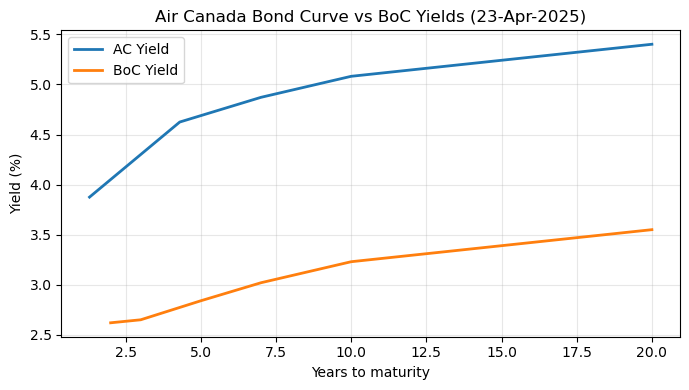

In [11]:
# AC Credit Spread Plot
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt

bond_data = pd.DataFrame({
    'mat_date': pd.to_datetime([dt.date(2026,8,15), dt.date(2029,8,15)]),
    'ytm_%'   : [3.875, 4.625]
})
bond_data['years'] = (bond_data['mat_date']
                     - pd.Timestamp.today().normalize()).dt.days / 365.25

goc_curve = pd.Series({2:2.62,3:2.65,5:2.84,7:3.02,10:3.23,20:3.55})

bond_data['goc_%'] = np.interp(bond_data['years'],
                               goc_curve.index, goc_curve.values)

sprd_bp   = (bond_data['ytm_%'].iloc[-1] - bond_data['goc_%'].iloc[-1]) * 100
extra_yrs = [7,10,15,20]
extra     = pd.DataFrame({'years':extra_yrs})
extra['goc_%'] = np.interp(extra['years'], goc_curve.index, goc_curve.values)
extra['ytm_%'] = extra['goc_%'] + sprd_bp/100

bond_long = pd.concat([bond_data, extra], ignore_index=True).sort_values('years')

plt.figure(figsize=(7,4))
plt.plot(bond_long['years'], bond_long['ytm_%'], lw=2, label='AC Yield')
plt.plot(goc_curve.index, goc_curve.values,   lw=2, label='BoC Yield')
plt.xlabel('Years to maturity'); plt.ylabel('Yield (%)')
plt.title('Air Canada Bond Curve vs BoC Yields (23-Apr-2025)')
plt.grid(alpha=.3); plt.legend(); plt.tight_layout(); plt.show()


In [12]:
import pandas as pd
import numpy as np
import datetime as dt

# The two AC Bond YTM's (estimated)
bond_data = pd.DataFrame({
    'mat_date': pd.to_datetime([dt.date(2026,8,15), dt.date(2029,8,15)]),
    'ytm_%'   : [3.875, 4.675]
})
bond_data['years'] = (bond_data['mat_date'] - pd.Timestamp('2025-04-23')).dt.days / 365.25

# BoC yield curve
goc_curve = pd.Series({2:2.62, 3:2.65, 5:2.84, 7:3.02, 10:3.23, 20:3.55})

# BoC interpolated yields
bond_data['goc_%'] = np.interp(bond_data['years'],
                               goc_curve.index, goc_curve.values)

# Credit spread computation in bps
bond_data['spread_bp'] = (bond_data['ytm_%'] - bond_data['goc_%']) * 100

# Select longest-dated bond spread
longest = bond_data['years'].idxmax()
spread_used = bond_data.loc[longest, 'spread_bp']

print("\nPer-bond spreads (bps):")
print(bond_data[['mat_date','ytm_%','goc_%','spread_bp']].to_string(index=False))
print(f"\n→ Using the {int(bond_data.loc[longest,'years']*12)}-month bond spread of {spread_used:.1f} bps for all longer tenors.")



Per-bond spreads (bps):
  mat_date  ytm_%    goc_%  spread_bp
2026-08-15  3.875 2.620000 125.500000
2029-08-15  4.675 2.774651 190.034908

→ Using the 51-month bond spread of 190.0 bps for all longer tenors.
